# Ensemble Model

## Libraries

In [1]:
import pandas as pd
import numpy as np

import h2o
from h2o.estimators import H2OGradientBoostingEstimator

from plotnine import *
from sklearn.metrics import precision_score, recall_score, f1_score
import scikitplot as skplt

## Data Import

In [2]:
dt = pd.read_csv('processing/test_train_split.csv')

lyr_pred_df = pd.read_csv('model_prs/lyrics.csv', index_col=0)
img_pred_df = pd.read_csv('model_prs/images.csv', index_col=0)
music_pred_df = pd.read_csv('model_prs/music.csv', index_col=0)

In [3]:
genre_cols = ['Big_Band','Blues_Contemporary','Country_Traditional','Dance','Electronica',
              'Experimental','Folk_International','Gospel','Grunge_Emo','Hip_Hop_Rap',
              'Jazz_Classic','Metal_Alternative','Metal_Death','Metal_Heavy','Pop_Contemporary',
              'Pop_Indie','Pop_Latin','Punk','Reggae','RnB_Soul','Rock_Alternative',
              'Rock_College','Rock_Contemporary','Rock_Hard','Rock_Neo_Psychedelia']

In [4]:
for l,d in zip(['lyr','img','music'],[lyr_pred_df, img_pred_df, music_pred_df]):
    d.columns = [l+'_'+c if c in genre_cols else c for c in d.columns]

In [5]:
df = (dt.loc[:,['track_id','genre','image_name','is_test']]
        .merge(lyr_pred_df.drop(['genre','src'], axis=1), how='left', on=['track_id'])
        .merge(img_pred_df.drop(['genre','src'], axis=1), how='left', on=['image_name'])
        .merge(music_pred_df, how='left', on=['track_id']))

## Model

In [6]:
# h2o.shutdown()
h2o.init(max_mem_size="4G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.1" 2018-10-16 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.1+13-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/zt/pvf5q9vd0wd8r31bcqn7j6zw0000gn/T/tmpc2jc6e6u
  JVM stdout: /var/folders/zt/pvf5q9vd0wd8r31bcqn7j6zw0000gn/T/tmpc2jc6e6u/h2o_andrewsang_started_from_python.out
  JVM stderr: /var/folders/zt/pvf5q9vd0wd8r31bcqn7j6zw0000gn/T/tmpc2jc6e6u/h2o_andrewsang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_andrewsang_cfds8w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [7]:
# set up data frames
hf = h2o.H2OFrame(df)
hf["genre"] = hf["genre"].asfactor()

train = hf[hf['is_test']==0,:] 
test = hf[hf['is_test']==1,:]
valid = hf[hf['is_test']==2,:]

X = hf.columns[4:]
y = 'genre'

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
# gbm = H2OGradientBoostingEstimator(seed=1234,
#                                    ntrees=100,
#                                    learn_rate=0.03,
#                                    learn_rate_annealing=.99,
#                                    max_depth=5,
#                                    sample_rate=0.8,
#                                    col_sample_rate=0.8,
#                                    stopping_rounds=2,
#                                    balance_classes=True,
#                                    max_after_balance_size=3.0,
#                                    min_rows=50)
# gbm.train(x=X, y=y, training_frame=train, validation_frame=test)
# 
# model_path = h2o.save_model(model=gbm, path="models", force=True)
# GBM_model_python_1599409688140_8

gbm = h2o.load_model('models/GBM_model_python_1599409688140_8')

In [9]:
gbm.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_model_python_1599409688140_8',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_model_python_1599409688140_8'},
  'input': None},
 'training_frame': {'default': None, 'actual': None, 'input': None},
 'validation_frame': {'default': None, 'actual': None, 'input': None},
 'nfolds': {'default': 0, 'actual': 0, 'input': 0},
 'keep_cross_validation_models': {'default': True,
  'actual': True,
  'input': True},
 'keep_cross_validation_predictions': {'default': False,
  'actual': False,
  'input': False},
 'keep_cross_validation_fold_assignment': {'default': False,
  'actual': False,
  'input': False},
 'score_each_iteration': {'default': False, 'actual': False, 'input': False},
 'score_tree_interval': {'default': 0, 'actual': 0, 'input': 0},
 'fold_assignment': {'default': 'AUTO', 'actual': None, 'input': 'AUTO'},
 'fold_column': {'de

In [159]:
# gbm.scoring_history()

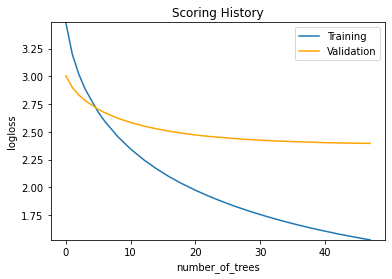

In [10]:
gbm.plot(metric='logloss', timestep='number_of_trees')

In [65]:
from h2o.tree import H2OTree
tree = H2OTree(model = gbm, tree_number = 46, tree_class = 'Hip_Hop_Rap')
print(tree.tree_decision_path)

If ( lyr_Hip_Hop_Rap >= 0.3388672 ) {

	If ( music_Hip_Hop_Rap >= 0.06037053 or music_Hip_Hop_Rap is NaN ) {
	
		If ( img_Hip_Hop_Rap >= 0.015728122 or img_Hip_Hop_Rap is NaN ) {
		
			If ( lyr_Pop_Latin >= 0.008010083 ) {
			
				If ( music_Rock_Neo_Psychedelia >= 0.006108415 ) {
				
					Predicted value: -0.013609298
					
				} else {
				
					Predicted value: 0.013890794
					
				}
			} else {
			
				If ( music_RnB_Soul >= 0.21360508 ) {
				
					Predicted value: -0.0033342827
					
				} else {
				
					Predicted value: 0.019642675
					
				}
			}
		} else {
		
			If ( img_Big_Band >= 0.003598269 or img_Big_Band is NaN ) {
			
				If ( img_Blues_Contemporary >= 0.019308649 ) {
				
					Predicted value: 0.0133696
					
				} else {
				
					Predicted value: -0.022725983
					
				}
			} else {
			
				Predicted value: 0.021982882
				
			}
		}
	} else {
	
		If ( music_Hip_Hop_Rap >= 0.024762185 ) {
		
			If ( img_Hip_Hop_Rap >= 0.060606655 ) {
			
				If ( music_Rock_Colle

In [64]:
from h2o.tree import H2OTree
tree = H2OTree(model = gbm, tree_number = 46, tree_class = 'Country_Traditional')
print(tree.tree_decision_path)

If ( music_Country_Traditional >= 0.17041412 ) {

	If ( img_Country_Traditional >= 0.06002449 or img_Country_Traditional is NaN ) {
	
		If ( music_Jazz_Classic >= 0.0049342606 ) {
		
			If ( music_Experimental >= 0.031667512 ) {
			
				Predicted value: 0.03543443
				
			} else {
			
				If ( img_Metal_Alternative >= 0.015838273 ) {
				
					Predicted value: 0.018485583
					
				} else {
				
					Predicted value: 0.0020229293
					
				}
			}
		} else {
		
			If ( lyr_Country_Traditional >= 0.0077920277 or lyr_Country_Traditional is NaN ) {
			
				If ( img_Grunge_Emo >= 0.024288408 ) {
				
					Predicted value: 0.028110001
					
				} else {
				
					Predicted value: 0.019376813
					
				}
			} else {
			
				If ( img_Experimental >= 0.008497364 or img_Experimental is NaN ) {
				
					Predicted value: -0.016376134
					
				} else {
				
					Predicted value: 0.0067422297
					
				}
			}
		}
	} else {
	
		If ( img_Country_Traditional >= 0.013298048 ) {
		
			If ( img_Metal_Al

In [66]:
from h2o.tree import H2OTree
tree = H2OTree(model = gbm, tree_number = 46, tree_class = 'Metal_Death')
print(tree.tree_decision_path)

If ( music_Metal_Death >= 0.21578006 ) {

	If ( lyr_Metal_Death >= 0.10152452 or lyr_Metal_Death is NaN ) {
	
		If ( img_Metal_Heavy >= 0.24907494 ) {
		
			If ( img_Experimental >= 0.036215875 ) {
			
				If ( img_Metal_Heavy >= 0.26661474 ) {
				
					Predicted value: 0.0025109344
					
				} else {
				
					Predicted value: -0.02797112
					
				}
			} else {
			
				If ( img_Metal_Death >= 0.1621237 or img_Metal_Death is NaN ) {
				
					Predicted value: 0.019381763
					
				} else {
				
					Predicted value: -0.008560796
					
				}
			}
		} else {
		
			If ( img_Rock_College >= 0.09423549 ) {
			
				If ( img_Electronica >= 0.013766009 or img_Electronica is NaN ) {
				
					Predicted value: 0.010796713
					
				} else {
				
					Predicted value: -0.019299377
					
				}
			} else {
			
				If ( img_Hip_Hop_Rap >= 0.04852242 ) {
				
					Predicted value: 0.029366693
					
				} else {
				
					Predicted value: 0.016999511
					
				}
			}
		}
	} else {
	
		If ( lyr_Exper

In [68]:
from h2o.tree import H2OTree
tree = H2OTree(model = gbm, tree_number = 46, tree_class = 'Pop_Indie')
print(tree.tree_decision_path)

If ( img_Pop_Indie >= 0.13505058 ) {

	If ( lyr_Pop_Indie >= 0.08721811 or lyr_Pop_Indie is NaN ) {
	
		If ( img_Hip_Hop_Rap >= 0.040601023 ) {
		
			If ( img_Grunge_Emo >= 0.031462174 ) {
			
				Predicted value: -0.005819095
				
			} else {
			
				If ( img_Punk >= 0.072227694 ) {
				
					Predicted value: 0.066865094
					
				} else {
				
					Predicted value: 0.023271644
					
				}
			}
		} else {
		
			If ( img_Pop_Indie >= 0.2951533 ) {
			
				If ( img_Rock_Neo_Psychedelia >= 0.059161622 ) {
				
					Predicted value: 0.032356203
					
				} else {
				
					Predicted value: 0.0118855275
					
				}
			} else {
			
				If ( music_Pop_Indie >= 0.068924904 or music_Pop_Indie is NaN ) {
				
					Predicted value: 0.010659149
					
				} else {
				
					Predicted value: -0.0021198466
					
				}
			}
		}
	} else {
	
		If ( img_Experimental >= 0.008856969 or img_Experimental is NaN ) {
		
			If ( img_Pop_Indie >= 0.2951533 ) {
			
				If ( img_Punk >= 0.033348996 ) {
				
					

In [69]:
from h2o.tree import H2OTree
tree = H2OTree(model = gbm, tree_number = 46, tree_class = 'Experimental')
print(tree.tree_decision_path)

If ( img_Experimental >= 0.12194293 ) {

	If ( lyr_Pop_Indie >= 0.100989394 ) {
	
		If ( music_Experimental >= 0.029199338 or music_Experimental is NaN ) {
		
			If ( img_Electronica >= 0.10591942 ) {
			
				Predicted value: -0.023777375
				
			} else {
			
				If ( img_Grunge_Emo >= 0.028532347 ) {
				
					Predicted value: 0.029825175
					
				} else {
				
					Predicted value: 0.013857208
					
				}
			}
		} else {
		
			If ( img_Gospel >= 0.021762058 ) {
			
				Predicted value: 0.0382453
				
			} else {
			
				If ( music_Rock_Hard >= 0.13842368 ) {
				
					Predicted value: 0.028602952
					
				} else {
				
					Predicted value: -0.0029191005
					
				}
			}
		}
	} else {
	
		If ( img_Experimental >= 0.18596536 ) {
		
			If ( img_Blues_Contemporary >= 0.007792093 ) {
			
				If ( img_Jazz_Classic >= 0.0143078985 or img_Jazz_Classic is NaN ) {
				
					Predicted value: 0.032518547
					
				} else {
				
					Predicted value: 0.012658224
					
				}
			} else {
			
			

## Feature Importance

In [12]:
varimp = pd.DataFrame(gbm.varimp(), columns=['ftr','raw','scale','perc'])

In [14]:
varimp.shape

(75, 4)

In [16]:
varimp = pd.DataFrame(gbm.varimp(), columns=['ftr','raw','scale','perc'])
varimp.loc[:, 'typ'] = varimp['ftr'].map(lambda s: s.split('_')[0])
var_list = varimp.sort_values('perc', ascending=False)['ftr']
var_cat = pd.Categorical(varimp['ftr'], categories=var_list)
varimp = varimp.assign(ftr_cat = var_cat)

/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


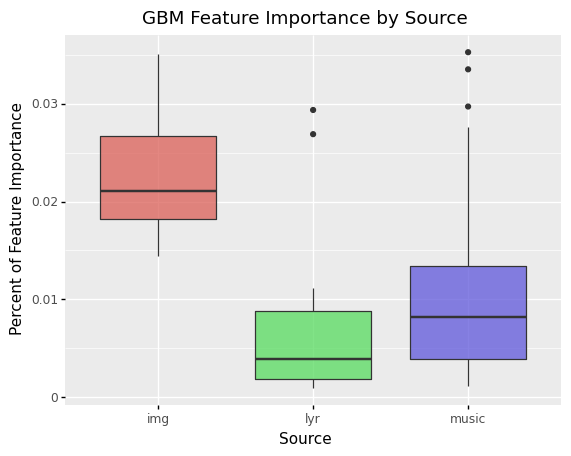

<ggplot: (7041534617)>

In [38]:
(ggplot(varimp, aes(x='typ', y='perc', fill='typ')) +
    geom_boxplot(alpha=0.75) +
    theme(legend_position='none') +
    xlab('Source') +
    ylab('Percent of Feature Importance') +
    ggtitle('GBM Feature Importance by Source'))

/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


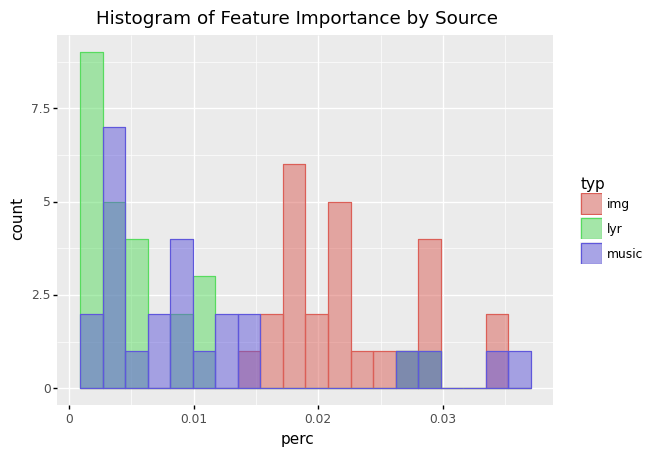

<ggplot: (7040811593)>

In [39]:
(ggplot(varimp, aes(x='perc', fill='typ', color='typ')) + 
    geom_histogram(bins=20, alpha=0.5, position='identity') +
    ggtitle('Histogram of Feature Importance by Source'))

In [41]:
pd.options.display.max_rows = 999
varimp

,ftr,raw,scale,perc,typ,ftr_cat
0,music_Hip_Hop_Rap,24284.751953,1.000000,0.035256,music,music_Hip_Hop_Rap
1,img_Blues_Contemporary,24186.550781,0.995956,0.035113,img,img_Blues_Contemporary
2,img_Big_Band,23702.820312,0.976037,0.034411,img,img_Big_Band
3,music_Metal_Death,23079.976562,0.950390,0.033507,music,music_Metal_Death
4,music_Jazz_Classic,20462.355469,0.842601,0.029707,music,music_Jazz_Classic
5,lyr_Pop_Latin,20219.251953,0.832590,0.029354,lyr,lyr_Pop_Latin
6,img_Metal_Heavy,20078.277344,0.826785,0.029149,img,img_Metal_Heavy
7,img_Reggae,19821.611328,0.816216,0.028776,img,img_Reggae
8,img_Grunge_Emo,19456.593750,0.801186,0.028247,img,img_Grunge_Emo
9,img_Electronica,19449.025391,0.800874,0.028236,img,img_Electronica


## Model interpretation / Performance

In [146]:
def print_output(col_type, weight_type, p=None, pred_max=None):
    if p is not None and pred_max is not None:
        pass
    else:
        p = grab_preds(col_type)
        pred_max = p.iloc[:, :25].idxmax(axis='columns').reset_index(drop=True)
    
    accuracy = np.mean(pred_max == p['genre'])
    precision = precision_score(p['genre'].values.tolist(), pred_max.values.tolist(),
                                average=weight_type, zero_division=0)
    recall = recall_score(p['genre'].values.tolist(), pred_max.values.tolist(),
                          average=weight_type, zero_division=0)
    f1 = f1_score(p['genre'].values.tolist(), pred_max.values.tolist(),
                  average=weight_type, zero_division=0)
    
    print('accuracy is {0:.4f}'.format(accuracy))
    for l,m in zip(['precision','recall','f1'],[precision, recall, f1]):
        print('{0} {1} is {2:.4f}'.format(l, weight_type, m))
        
    return p, pred_max, (pd.DataFrame([accuracy, precision, recall, f1]).T
                                 .rename(columns={0:'accuracy',
                                                  1:'precision',
                                                  2:'recall', 
                                                  3:'f1'}))

def grab_preds(col_type):
    cols = [c for c in df.columns if col_type in c]
    cols.append('genre')
    idf = df.loc[df['is_test']==2, cols]
    idf.columns = [c[len(col_type)+1:] if col_type in c else c for c in idf.columns]
    
    return idf.reset_index(drop=True)    

gbm prediction progress: |████████████████████████████████████████████████| 100%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

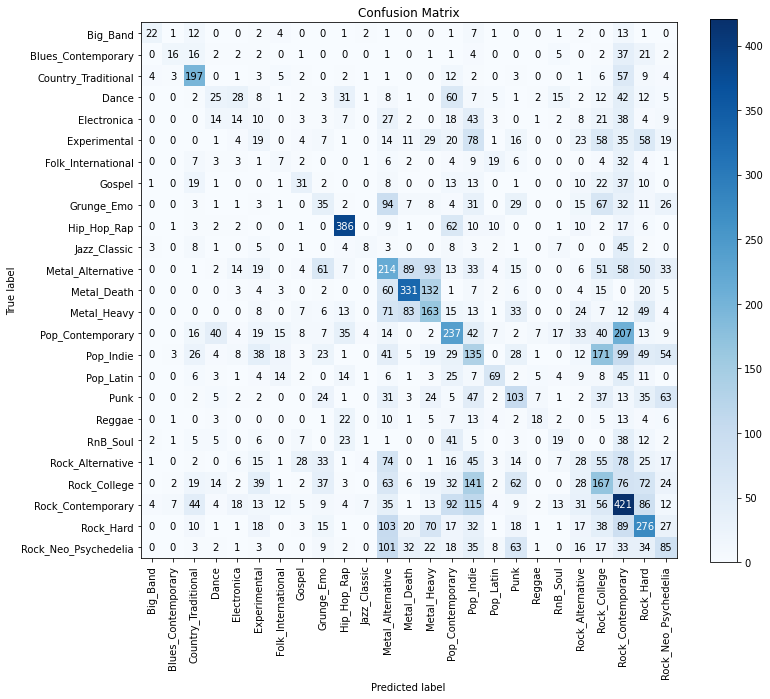

In [147]:
valid_pred = gbm.predict(valid).as_data_frame()['predict']

skplt.metrics.plot_confusion_matrix(df.loc[df['is_test']==2, 'genre'], 
                                    valid_pred, 
                                    normalize=False,
                                    x_tick_rotation=90,
                                    figsize=(12,10))

In [148]:
# valid accuracy using gbm
pred_max = valid_pred.copy()
p = df.loc[df['is_test']==2, 'genre'].reset_index().copy()
p, pred_max, gbm_out = print_output('gbm', 'weighted', p=p, pred_max=pred_max)

accuracy is 0.2869
precision weighted is 0.2799
recall weighted is 0.2869
f1 weighted is 0.2768


In [149]:
# valid accuracy using just lyrics
p, pred_max, lyr_out = print_output('lyr', 'weighted')

accuracy is 0.2254
precision weighted is 0.1977
recall weighted is 0.2254
f1 weighted is 0.1937


In [150]:
# valid accuracy using just image
p, pred_max, img_out = print_output('img', 'weighted')

accuracy is 0.1864
precision weighted is 0.1604
recall weighted is 0.1864
f1 weighted is 0.1658


In [151]:
# valid accuracy using just music
p, pred_max, music_out = print_output('music', 'weighted')

accuracy is 0.2845
precision weighted is 0.2780
recall weighted is 0.2845
f1 weighted is 0.2554


In [152]:
pd.options.display.float_format = '{:,.3f}'.format

tbl = pd.DataFrame()
for l,d in zip(['gbm','lyr','img','music'],[gbm_out, lyr_out, img_out, music_out]):
    dt = d.assign(src=l)
    tbl = pd.concat([tbl, dt])
tbl = tbl.loc[:,['src','accuracy','precision','recall','f1']].set_index('src').reset_index()
tbl

,src,accuracy,precision,recall,f1
0,gbm,0.287,0.280,0.287,0.277
1,lyr,0.225,0.198,0.225,0.194
2,img,0.186,0.160,0.186,0.166
3,music,0.285,0.278,0.285,0.255


In [ ]:
#render dataframe as html
html = tbl.to_html()

#write html to file
text_file = open("results.html", "w")
text_file.write(html)
text_file.close()